<a href="https://colab.research.google.com/github/vasem-1/SixSigma/blob/main/Copy_of_SixSigma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reporte de Simulación: Optimización del Proceso de Alineamiento Técnico

**Autor:** Víctor Asem
**Fecha:** 12 de Diciembre, 2025
**Versión del Modelo:** 1.2 (Detalle Matemático Extendido)

---

## 1. Introducción y Propósito

El presente documento detalla el análisis del flujo de **Alineamiento Técnico** entre proveedores (Suppliers) y el equipo de ingeniería. El propósito fundamental de este estudio es identificar, cuantificar y mitigar los riesgos asociados a los tiempos de ciclo (Lead Time) en la validación de definiciones técnicas críticas.

El problema central que aborda este modelo es la variabilidad e incertidumbre en los cronogramas de ejecución, provocada por múltiples iteraciones (bucles de rechazo y corrección) debido a discrepancias técnicas, falta de claridad en los requerimientos o entregables de baja calidad inicial. El objetivo es transitar de un enfoque reactivo a uno predictivo mediante simulación estocástica.

---

## 2. Descripción del Modelo y Metodología

### 2.1 Alcance y Simplificación
Este modelo constituye una **simplificación y un piloto conceptual** diseñado para validar la lógica de interacción entre las distintas áreas. Se asumen comportamientos estandarizados y distribuciones teóricas para representar la variabilidad. El objetivo es testear la sensibilidad del sistema ante cambios en las variables críticas antes de ampliar el modelo para replicar la casuística completa del proyecto real.

### 2.2 Arquitectura Técnica
La simulación fue desarrollada en **Python** utilizando el paradigma de **Programación Orientada a Objetos (OOP)**. Cada etapa del proceso se modeló como una clase independiente (`CajaProceso` y sus subclases) con atributos propios de tiempo y lógica de decisión probabilística, permitiendo una arquitectura modular y escalable.

### 2.3 Metodología de Simulación
Se utilizó una metodología **Estocástica basada en el Método de Monte Carlo**. A diferencia de los modelos deterministas que usan promedios fijos, este modelo incorpora la aleatoriedad inherente al proceso real.

* **Estabilidad Estadística (Teorema del Límite Central):** Se estableció un volumen de **30,000 iteraciones** por escenario. Basándonos en la Ley de los Grandes Números, este alto volumen garantiza que los resultados converjan hacia la esperanza matemática real del sistema, minimizando el error estándar y permitiendo modelar con precisión las "colas" de la distribución (los casos extremos de riesgo) que no serían visibles con una muestra pequeña.
* **Variables de Salida:** Tiempo total de flujo (Lead Time), número de ciclos (retrabajos) y tiempos por área.

---

## 3. Estructura del Flujo y Lógica Matemática

El modelo conecta secuencialmente las siguientes entidades o "cajas", regidas por funciones matemáticas de comportamiento:

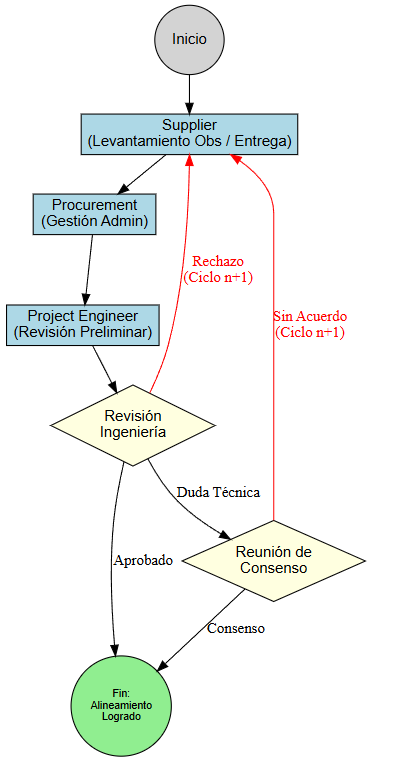

### 3.1 Caja Supplier (Curva de Aprendizaje Exponencial)
Representa el tiempo que toma al proveedor corregir observaciones. Se asume que el proveedor aprende con cada iteración.

* **Fórmula de Tiempo (Decaimiento Exponencial):**
    $$T_{correccion} = T_{base} \times (Factor)^{n-2}$$
    *Donde $n$ es el número de ciclo actual (para $n \ge 2$).*

* **Tabla de Comportamiento (Base = 10 días, Factor = 0.8):**

| Ciclo | Tiempo Máx (Días) | Tiempo Máx (Meses) |
| :--- | :--- | :--- |
| 1 (Entrega) | 0.00 | 0.0 |
| 2 (1ra Corrección) | 10.00 | 0.5 |
| 3 (2da Corrección) | 8.00 | 0.4 |
| 4 (3ra Corrección) | 6.40 | 0.32 |

### 3.2 Cajas Lineales (Procurement y PE)
Estas etapas no poseen lógica de ramificación compleja (siempre avanzan), pero su duración es variable. Se modelan mediante una **Distribución Triangular**, la cual es ideal para estimaciones de expertos cuando se conocen los escenarios optimista, más probable y pesimista.

* **Ecuación de Tiempo:**
    El tiempo $t$ es una variable aleatoria continua definida por la función de densidad de probabilidad triangular:
    $$t \sim Triangular(a, c, b)$$
    
    Donde:
    * $a$ = Tiempo Mínimo (Optimista)
    * $c$ = Tiempo Moda (Más Probable)
    * $b$ = Tiempo Máximo (Pesimista)

    La generación estocástica en cada iteración $i$ sigue la regla:
    $$T_i = \begin{cases} a + \sqrt{U(b-a)(c-a)} & \text{si } U < \frac{c-a}{b-a} \\ b - \sqrt{(1-U)(b-a)(b-c)} & \text{si } U \ge \frac{c-a}{b-a} \end{cases}$$
    *(Donde $U$ es un número aleatorio uniforme entre 0 y 1).*

### 3.3 Caja Ingeniería (Probabilidad de Rechazo Exponencial)
Ingeniería evalúa el entregable. La probabilidad de rechazo disminuye a medida que el documento madura.

* **Fórmula de Probabilidad:**
    $$P(Rechazo) = P_{base} \times (Factor)^{n-1}$$

* **Tabla de Probabilidades (Base = 0.95, Factor = 0.8):**

| Ciclo | Probabilidad de Rechazo | Probabilidad de Avance |
| :--- | :--- | :--- |
| 1 | 95.0% | 5.0% |
| 2 | 76.0% | 24.0% |
| 3 | 60.8% | 39.2% |

### 3.4 Caja Reunión (Crecimiento Lineal de Éxito)
Si hay dudas complejas, se deriva a reunión. La probabilidad de éxito (consenso) aumenta linealmente con cada intento.

* **Fórmula de Probabilidad de Éxito (Lineal):**
    $$P(Exito) = P_{min} + (n - 1) \times Factor_{crecimiento}$$
    *Acotado a un máximo del 95%.*

* **Tabla de Probabilidades (Base = 0.10, Crecimiento = 0.15):**

| Ciclo | Probabilidad de Éxito (Aprobación) | Probabilidad de Fallo (Vuelta atrás) |
| :--- | :--- | :--- |
| 1 | 10.0% | 90.0% |
| 2 | 25.0% | 75.0% |
| 3 | 40.0% | 60.0% |
| 4 | 55.0% | 45.0% |
| 5 | 70.0% | 30.0% |

---

## 4. Resultados de la Simulación (Estado Actual)

Tras ejecutar 30,000 iteraciones con los parámetros de la línea base, se obtuvieron los siguientes resultados estadísticos.
*(Nota: Conversión aproximada asumiendo 20 días hábiles por mes)*.

### 4.1 Resumen Estadístico
| Métrica | Valor (Días Hábiles) | Valor (Meses Aprox.) | Desviación Estándar |
| :--- | :--- | :--- | :--- |
| **Tiempo Promedio de Ciclo** | **66.92 días** | **3.35 meses** | $\pm$ 21.3 días |
| **Tiempo Mínimo** | 10.9 días | 0.55 meses | - |
| **Tiempo Máximo** | 122.4 días | 6.12 meses | - |
| **Iteraciones Promedio** | 4.63 vueltas | - | $\pm$ 1.8 vueltas |

### 4.2 Distribución de Tiempos
El siguiente histograma muestra la dispersión de los tiempos de entrega. Se observa una clara asimetría positiva, indicando un alto riesgo de retrasos que superan los 3 meses de gestión.

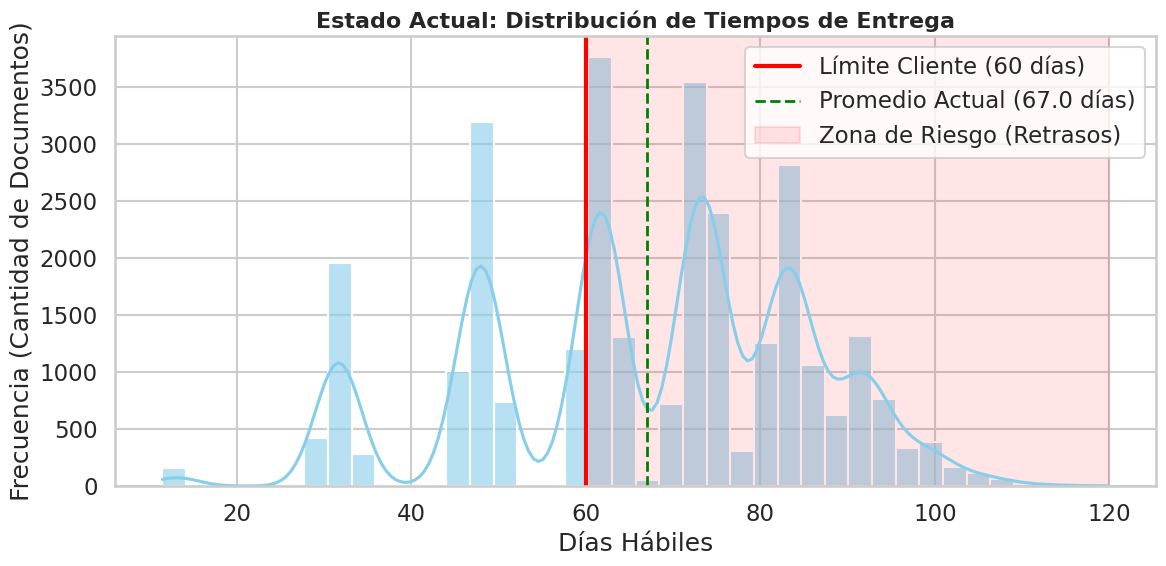

### 4.3 Diagrama de Caja (Boxplot) por Área
La mayor variabilidad y consumo de tiempo se concentran en Ingeniería y el Supplier.

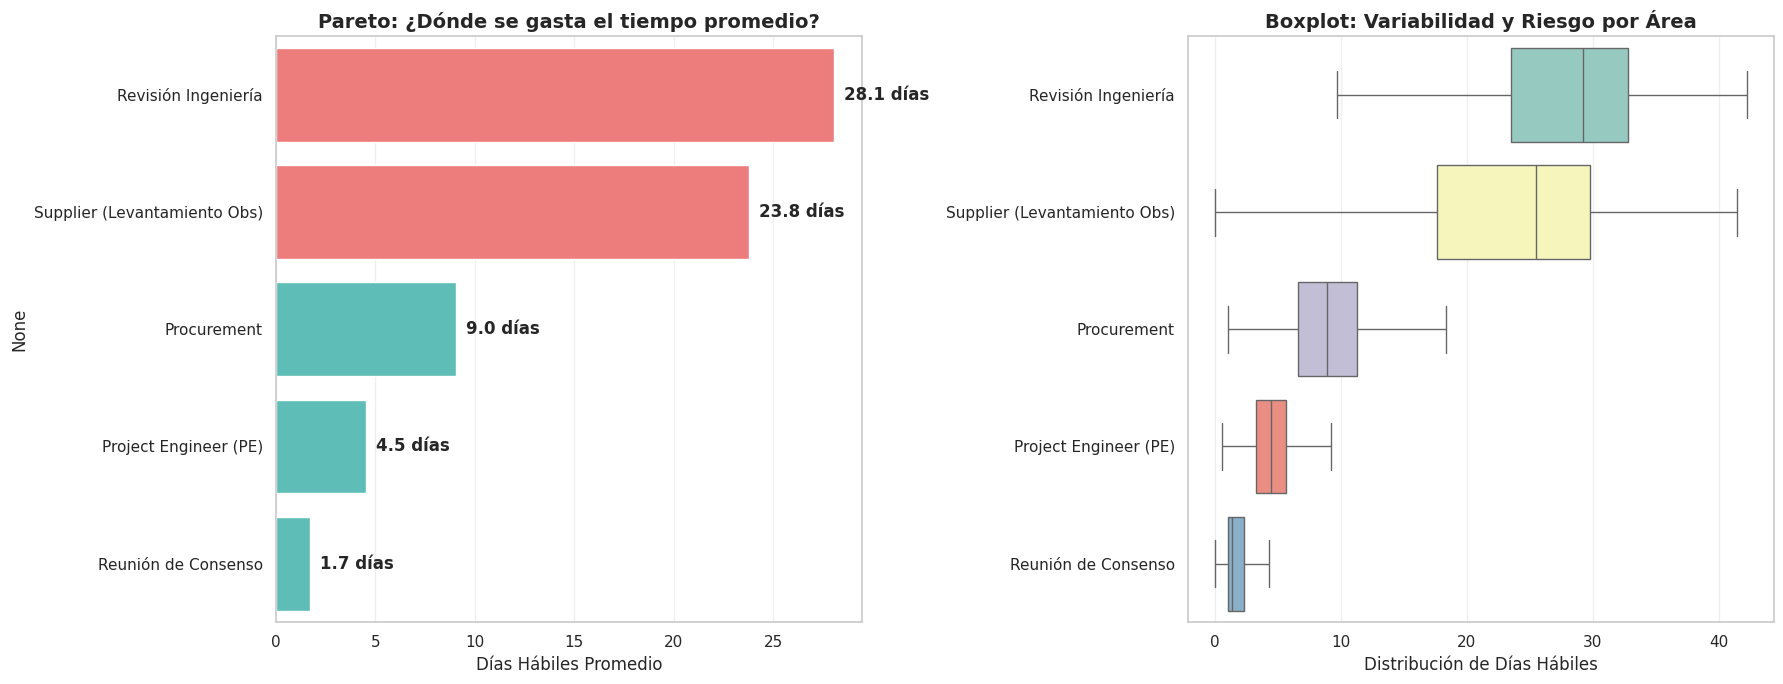

## 5. Análisis de Sensibilidad

Se realizó un análisis de sensibilidad modificando variables clave para medir su impacto. A continuación se describe el significado operativo de cada cambio de parámetro:

**Configuración de Escenarios:**

1.  **Supplier Experto (Curva de Aprendizaje):**
    * *Cambio:* Factor de tiempo $0.8 \to 0.5$.
    * *Significado:* Se simula un proveedor con mayor capacidad técnica. Si en el escenario base (0.8), tras una primera corrección de 10 días, la segunda toma 8 días; en este escenario (0.5), la segunda corrección toma solo 5 días. Representa una capacidad de reacción el doble de rápida ante observaciones.

2.  **Ingeniería Ágil (Tiempo de Respuesta):**
    * *Cambio:* Tiempo base $10 \to 5$ días.
    * *Significado:* Se reduce a la mitad el SLA (Acuerdo de Nivel de Servicio) interno de revisión de ingeniería para documentos re-ingresados.

3.  **Entregas de Calidad (Madurez Inicial):**
    * *Cambio:* Probabilidad de rechazo inicial $95\% \to 50\%$.
    * *Significado:* Se simula que el documento ingresa con mayor calidad. En lugar de tener una certeza casi absoluta de rechazo en la primera vuelta (95%), existe una probabilidad real (50/50) de que el documento sea aceptable o requiera cambios menores, reduciendo drásticamente los bucles iniciales.

4.  **Reuniones Resolutivas (Capacidad de Consenso):**
    * *Cambio:* Probabilidad de éxito base $20\% \to 80\%$.
    * *Significado:* Las reuniones dejan de ser informativas y pasan a ser resolutivas. Se asume que quienes asisten tienen la autoridad y el alineamiento necesario para cerrar los temas en la primera sesión (80% de éxito) en lugar de requerir múltiples reuniones.

**Tabla de Resultados de Sensibilidad:**

| Ranking | Escenario | Variable Modificada | Impacto (% Reducción Tiempo) | Tiempo Final (Meses) |
| :--- | :--- | :--- | :--- | :--- |
| **1** | **Entregas de Calidad** | $P(Rechazo)_{inicial}$ | **- 48.6%** | **~ 1.7 meses** |
| **2** | **Ingeniería Ágil** | $T_{revision}$ | **- 27.8%** | **~ 2.4 meses** |
| **3** | **Reuniones Resolutivas** | $P(Exito)_{reunion}$ | **- 12.7%** | **~ 2.9 meses** |
| **4** | **Supplier Experto** | $Factor_{aprendizaje}$ | **- 8.1%** | **~ 3.1 meses** |
---

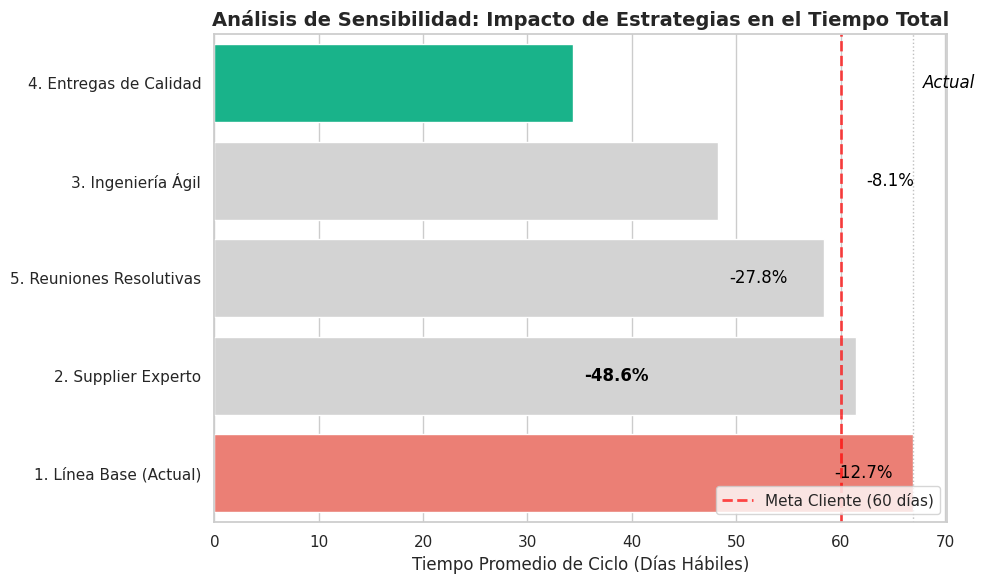

---

## 6. Conclusiones y Próximos Pasos

### 6.1 Conclusiones
El modelo demuestra matemáticamente que la **calidad de entrada** es la variable más sensible del sistema. Esfuerzos aislados por acelerar la revisión (Ingeniería) o la corrección (Supplier) tienen un impacto marginal si la tasa de rechazo inicial se mantiene alta. Mejorar la calidad inicial podría reducir el tiempo promedio de **3.3 meses a 1.7 meses**.

### 6.2 Próximos Pasos
Para avanzar hacia la implementación operativa de estas mejoras, se establecen las siguientes acciones:

1.  **Implementación de Gatekeeping:** Establecer una revisión técnica preliminar (filtro) por parte del Project Engineer antes de ingresar documentos al flujo de Ingeniería.
2.  **Calibración con Datos Históricos:** Alimentar el modelo con datos reales de los últimos 6 meses para ajustar las distribuciones de probabilidad triangular.
3.  **Talleres de Alineamiento:** Realizar sesiones de trabajo previas con los proveedores críticos para clarificar los estándares de ingeniería antes de la primera emisión de documentos.